# Example for the `Speech-To-Text (STT)` API

This API allows you to easily perform prediction / search on audios / videos by  automatically loading models and calling associated function. 

You can identify models either by their name or by their associated language. To associate a model to a language, go to `models/stt/__init__.py` in the `_pretrained` variables (at the end of the file) you can see `'en' : 'pretrained_jasper'`. It means that when you are calling a function with `lang = 'en'`, it will load the `pretrained_jasper` model to perform prediction. 

Do not forget to download `pretrained_jasper` folder and put it in `pretrained_models` ! (link is in the README.md file)

Note : prediction / search can be performed either on audios either on videos (mp4) !

## Prediction

Simple demonstration of prediction. 

The prediction will split the audio by *frames* of a given amount of time and predict text for each frame. Then it will concatenate each text to build the complete transcription of the audio. 

**Note** : this demonstration is done on a short, clean and clear audio. Performances on *real* audios / videos are far worst ! You cannot (currently) use this API for real transcription / subtitles generation... However forsearching words it is quite powerful as I use the `edit distance` so it canwork even if words are bad written (note that the longer the pattern is, better the search will be). 

In [3]:
from models.stt import predict
from utils.audio import display_audio

filename = '../__test_datas/audio_en.wav'
pred = predict(filename, lang = 'en')

display_audio(filename)
pred

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Processing file ../__test_datas/audio_en.wav...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.91s/it]


[{'alignment': [{'end': 4,
    'id': -1,
    'start': 0.0,
    'text': 'the streets were narrow and unpaved but very fairly clean',
    'time': 4.0}],
  'filename': '../__test_datas/audio_en.wav',
  'text': 'the streets were narrow and unpaved but very fairly clean',
  'time': 4.055}]

## Search keyword in audio

The `search` function allows you to search a keyword in an audio / video and get all timestamps where this keyword has been found (with a given probability threshold). As the model is relatively poor for *transcription*, I use **partial alignment** to get the probability of the word at each position (cf README.md for explaination on partial alignment). 

Next, to find the approximately timestamp where the word has been pronounced, I get the start of the *frame* (as audio are splitted in frames of *n* sec) and get the relative position of the word in the frame's text. 

In the below example, the *unpaved* word seems to be approximately in themiddle of the text so I suggest it is approximately at themiddle of the audio : the estimated timestamp is at 1.9sec which is approximately the middle of the 4sec audio !

In this case the estimation is quite good as the frame is short (4sec) but this estimation is worst when audios are longer (with 30sec frame by default). It is the reason why, when displaying audio timestamps, I have added the `before` argument which wil display audio *n* sec before the predicted timestamp (by default to 2.5sec but you can increase it to 5 or 7.5sec if audios are longer / sparse (with silences)). 

In [3]:
from models.stt import search

filename = '../__test_datas/audio_en.wav'

r = search('unpaved', filename, model = 'pretrained_jasper')
print(r)

Result for searching keyword 'unpaved' :
Number of files : 1 / 1
Total number of occurences : 1
Files : Annotation of file ../__test_datas/audio_en.wav :
- Total annotation time : 4.000 sec
- Number of alignments : 1 (1 sub-parts)
- Speakers (n = 1) : [-1]

Occurences of 'unpaved' (1, threshold = 80.00%) :
- Timestamp 1.895 sec (p = 100.00 %) : [...]  unpaved but v [...]



In [2]:
r.display(before = 0.5)

## Build pretrained DeepSpeech

Note that the `pretrained_jasper` is the best compared to the `pretrained_deep_speech` but it is much bigger. If you want to use the `DeepSpeech` model, you first have to build it. 

Simply run these 2 lines and change, in the function above, the `lang = 'en'` by `model = 'pretrained_deep_speech'` and that's it ! All functions will use the `DeepSpeech2` model !

Note : it will automatically download pretrained weights in `pretrained_models/pretrained_weights/` foler (400Mb) so it can take some time depending on your internet connection bandwith ;)

In [ ]:
from models.stt import DeepSpeech
model = DeepSpeech.build_pretrained_deep_speech()
print(model)

## Edit distance demonstration

This example illustrates with longer example the **edit distance** with partial alignment for searching keyword in bad-spelled text (as described in the README file). 

The objective is to find *cat* in the text *the ct is here*

In [15]:
import numpy as np

from utils import plot, set_display_options
from utils.distance import edit_distance

set_display_options()

truth = 'the ct is here'
hypothesis = 'cat'

print("Edit distance without partial alignment :")
dist, matrix = edit_distance(hypothesis, truth, partial = False, return_matrix = True, normalize = False, verbose = True)

print("Edit distance with partial alignment :")
partial_dist, partial_matrix = edit_distance(hypothesis, truth, partial = True, return_matrix = True, normalize = False, verbose = True)

start_idx = np.argmin(partial_matrix[-1, 1:]) + 1 - len(hypothesis)
print("Best alignment : {}".format(truth[start_idx : start_idx + len(hypothesis)]))

Edit distance without partial alignment :
          t    h    e         c    t         i    s           h     e     r     e
   0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  11.0  12.0  13.0  14.0
c  1.0  1.0  2.0  3.0  4.0  4.0  5.0  6.0  7.0  8.0   9.0  10.0  11.0  12.0  13.0
a  2.0  2.0  2.0  3.0  4.0  5.0  5.0  6.0  7.0  8.0   9.0  10.0  11.0  12.0  13.0
t  3.0  2.0  3.0  3.0  4.0  5.0  5.0  6.0  7.0  8.0   9.0  10.0  11.0  12.0  13.0
Edit distance with partial alignment :
          t    h    e         c    t         i    s         h    e    r    e
   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
c  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
a  2.0  2.0  2.0  2.0  2.0  1.0  1.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0
t  3.0  2.0  3.0  3.0  3.0  2.0  1.0  2.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0
Best alignment :  ct


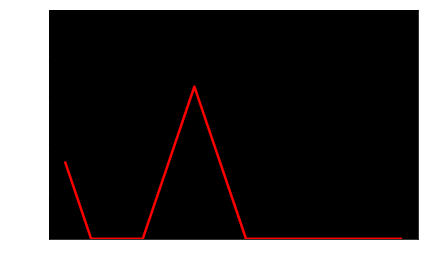

In [12]:
probability = 1. - partial_matrix[-1, 1:] / len(hypothesis)
plot(probability, ylim = (0, 1), xlabel = "caracter index", ylabel = "probability (%)")